## 스토어드 함수

* MySQL은 다양한 내장 함수로 제공되지 않는 기능을 스토어드 함수로 만들어서 사용할 수 있다.

### 스토어드 함수의 개념과 형식

In [ ]:
# 스토어드 함수의 기본 형식
DELIMITER $$
CREATE FUNCTION 스토어드_함수_이름(매개변수)
	RETURNS 반환형식
BEGIN

	<프로그래밍 코드 작성부분>
    RETURN 반환값;
END $$
DELIMITER ;
SELECT 스토어드_함수_이름();

#### 스토어드 프로시저와 차이점

* 스토어드 함수는 RETURNS 문으로 반환할 값의 데이터 형식을 지정하고, 본문 안에서는 RETURN문으로 하나의 값을 반환해야 한다.
* 스토어드 함수의 매개변수는 모두 입력 매개변수이다. IN을 붙이지 않는다.
* 스토어드 프로시저는 CALL로 호출하지만, 스토어드 함수는 SELECT문 안에서 호출된다.
* 스토어드 프로시저 안에서는 SELECT문을 사용할 수 있지만, 스토어드 함수 안에서는 SELECT문을 사용할 수 없다.
* 스토어드 프로시저는 여러 SQL문이나 숫자 계산 등의 다양한 용도로 사용하지만, 스토어드 함수는 어떤 계산을 통해서 하나의 값을 반환하는데 주로 사용한다.

### 스토어드 함수의 사용

* 스토어드 함수를 사용하기 위해서는 다음 SQL로 스토어드 함수 생성 권한을 혀용해줘야 한다.

In [ ]:
# 스토어드 함수 생성 권한 허용
SET GLOBAL log_bin_trust_function_creators = 1;

In [ ]:
# 숫자 2개의 함계를 계산하는 스토어드 함수
USE market_db;
DROP FUNCTION IF EXISTS sumFunc;
DELIMITER $$
CREATE FUNCTION sumFunc(number1 INT, number2 INT)
	RETURNS INT
# 정수형 결과 반환
BEGIN
	RETURN number1 + number2;
END $$
DELIMITER ;

SELECT sumFunc(100, 200) AS '합계';

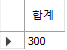

In [ ]:
# 데뷔 연도를 입력하면 활동 기간이 얼마나 되었는지 출력
DROP FUNCTION IF EXISTS calcYearFunc;
DELIMITER $$
CREATE FUNCTION calcYearFunc(dYear INT)
	RETURNS int
BEGIN
	DECLARE runYear INT;
    # 활동 횟수 = 현재 연도 - 데뷔 연도
    SET runYear = YEAR(CURDATE()) - dYear;
    RETURN runYear;
END $$
DELIMITER ;
SELECT calcYearFunc(2010) AS '활동 횟수';

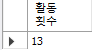

In [ ]:
# SELECT ~ INTO ~를 이용하여 함수의 반환값을 각 변수에 저장 후, 그 차이를 계산해서 출력
# 즉, 데뷔 연도와 활동 횟수 차이 출력
SELECT calcYearFunc(2007) INTO @debut2007;
SELECT calcYearFunc(2013) INTO @debut2013;
SELECT @debut2007-@debut2013 AS '2007과 2013 차이';

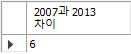

In [ ]:
# YEAR() 함수는 연도만 추출해주는 함수, calcYearFunc(연도)로 함수를 사용해서 각 회원별 활동 횟수 출력
SELECT mem_id, mem_name, calcYearFunc(YEAR(debut_date)) AS '활동 횟수'
FROM member;

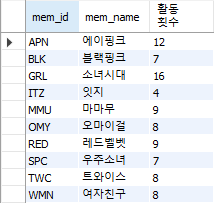

### 스토어드 함수의 내용 확인

In [ ]:
# 스토어드 함수의 내용 확인
SHOW CREATE FUNCTION 함수_이름;

* 위의 코드를 실행 후, Create Function에서 마우스 오른쪽 버튼을 클릭하고 Open Value in Viewer를 선택하면 Edit Data for Create Function(VARCHAR) 창의 Text탭에서 작성했던 스토어드 함수의 코드를 확인할 수 있다.

In [ ]:
# 함수의 삭제
DROP FUNCTION calcYearFunc;

## 커서로 한 행씩 처리하기

* 커서: 테이블에서 한 행씩 처리하기 위한 방식

### 커서의 기본 개념

* 커서는 첫 번째 행을 처리한 후에 마지막 행까지 한 명씩 접근해서 값을 처리
* 커서가 행의 시작을 가리킨 후에 한 행씩 차례대로 접근
* 커서는 대부분 스토어드 프로시저와 함께 사용됨

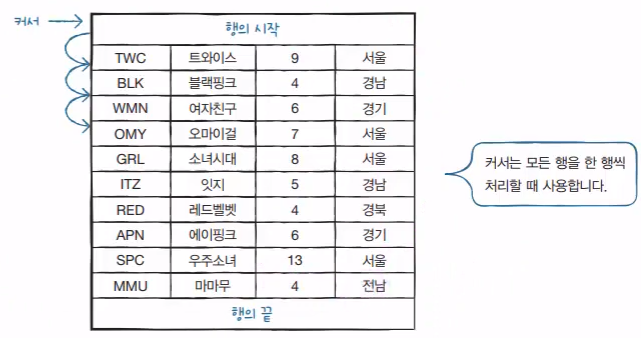
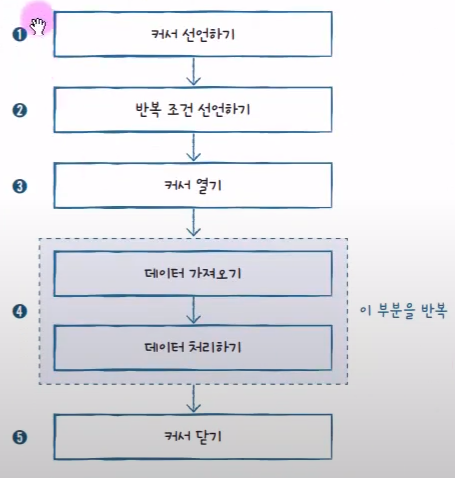

### 커서의 단계별 실습

* 회원(가수 그룹)의 평균 인원수를 구하는 스토어드 프로시저를 작성
* 커서를 활용하여 한 행씩 접근해서 회원의 인원수를 누적시키는 방식으로 처리

### 1. 사용할 변수 준비하기

* 회원의 평균 인원수를 계산하기 위해서 각 회원의 인원수(memNumber), 전체 인원의 합계(totNumber), 읽은 행의 수(cnt) 변수 3개를 준비한다.
* 전체 인원의 합계와 읽은 행의 수를 누적시켜야 하기 때문에 DEFAULT문을 사용해서 초기값을 0으로 설정

In [ ]:
# DEFAULT문을 사용해서 초기값을 0으로 설정
DECLARE memNumber INT;
DECLARE cnt INT DEFAULT 0;
DECLARE totNumber INT DEFAULT 0;

In [ ]:
# 행의 끝을 파악하기 위한 변수 endOfRow준비
# 처음에는 당연히 행의 끝이 아닐테니 FALSE로 초기화
DECLARE endOfRow BOOLEAN DEFAULT FALSE;

### 2. 커서 선언하기

* 커서라는 것은 결국 SELECT문임
* 회원 테이블을 조회하는 구문을 커서로 만들어 놓으면 된다. 커서 이름은 memberCursor로 지정

In [ ]:
# 커서 선언
DECLARE memberCursor CURSOR FOR
SELECT mem_number FROM member;

### 3. 반복 조건 선언하기

* 행의 끝에 다다르면 앞에서 선언한 endOfRow 변수를 TRUE로 설정
* DECLARE CONTINUE HANDLER는 반복 조건을 준비하는 예약어
* FOR NOT FOUND는 더 이상 행이 없을 때 이어진 문장을 수행
* 행이 끝나면 endOfRow에 TRUE를 대입한다.

In [ ]:
# 반복 조건 선언
DECLARE CONTINUE HANDLER
	FOR NOT FOUND SET endOfRow = TRUE;

### 4. 커서 열기

In [ ]:
# 커서 열기
OPEN memberCursor;

### 5. 행 반복하기

In [ ]:
# 행 반복하기
cursor_loop: LOOP
이 부분 반복
END LOOP cursor_loop

* cursor_loop는 반복할 부분의 이름을 지정한 것
* 이 코드는 무한 반복하기 때문에 코드 안에 반복문을 빠져나갈 조건이 필요함
* 앞에서 행의 끝에 다다르며 endOfRow를 TRUE로 변경하기로 설정
* 반복되는 부분엔 다음의 코드가 필수로 들어가야 한다.

In [ ]:
# 반복문을 빠져나갈 조건 필요
IF endOfRow THEN
	LEAVE cursor_loop;
END IF;

* LEAVE: 반복할 이름을 빠져나간다.
* 행의 끝에 다다르면 반복 조건을 선언한 3번에 의해서 endOfRow가 TRUE로 변경되고 반복되는 부분을 빠져나간다.

* 반복할 부분을 전체 표현해본다.
* FETCH: 한 행씩 읽어오는 것이다.
* 2번에서 커서를 선언할 때 인원수 행을 조회했으므로 memNumber 변수에는 각 회원의 인원수가 한 번에 하나씩 저장된다.
* SET 부분에서 읽은 행의 수를 하나씩 증가시키고, 인원 수도 totNumber에 계속 누적시킨다.

In [ ]:
# 반복할 부분을 전체 표현
cursor_loop: LOOP
	FETCH memberCursor INTO memNumber;
    
    IF endOfRow THEN
		LEAVE cursor_loop;
	END IF;
    
    SET cnt = cnt + 1;
    SET totNumber = totNumber + memNumber;
END LOOP cursor_loop;

### 커서의 통합 코드

In [ ]:
# 통합 코드
USE market_db;
DROP PROCEDURE IF EXISTS cursor_proc;
DELIMITER $$
CREATE PROCEDURE cursor_proc()
BEGIN
	DECLARE memNumber INT;
	DECLARE cnt INT DEFAULT 0;
	DECLARE totNumber INT DEFAULT 0;
	DECLARE endOfRow BOOLEAN DEFAULT FALSE;

	DECLARE memberCursor CURSOR FOR
		SELECT mem_number FROM member;

	DECLARE CONTINUE HANDLER
		FOR NOT FOUND SET endOfRow = TRUE;

	OPEN memberCursor;
    
    cursor_loop: LOOP
		FETCH memberCursor INTO memNumber;
    
		IF endOfRow THEN
			LEAVE cursor_loop;
		END IF;
    
		SET cnt = cnt + 1;
		SET totNumber = totNumber + memNumber;
	END LOOP cursor_loop;
    
	SELECT (totNumber/cnt) AS '회원의 평균 인원 수';
    
    CLOSE memberCursor;
END $$

In [ ]:
# 스토어드 프로시저 실행해서 결과를 확인
CALL cursor_proc();

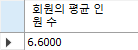

* 이번에 작성한 코든 MySQL의 내장 함수인 AVG()와 동일한 기능을 구현한 것
* 실제로 평균을 구할 때는 AVG()가 더 간단하고 편리하다.
* 커서는 스토어드 프로시저 안에 코드를 작성한다. 그리고 스토어드 프로시저를 실행하면 커서가 작동되는 것